# Fraud Detection System using Machine Learning

## Problem Statement

Credit card fraud poses a serious risk to financial institutions, with fraudulent transactions being extremely rare compared to legitimate ones. This results in highly imbalanced datasets, where traditional machine learning models often fail to detect rare fraud cases. The objective of this project is to build a fraud detection system that can accurately identify fraudulent transactions while minimizing false alarms, leveraging resampling techniques, robust evaluation metrics, and MLflow for experiment tracking and deployment readiness.

### Approach

1. **Data Understanding & Exploration**
2. **Data Preprocessing**
3. **Feature Engineering**
4. **Experiment Tracking with MLflow**
5. **Model Building**
6. **Model Evaluation**
7. **Hyperparameter Tuning**
8. **Final Model Selection & Deployment**
9. **Conclusion & Recommendations**

## Data Understanding and Exploration

The dataset contains credit card transactions made by European cardholders in Sept 2013. It includes 284,807 transactions, out of which only 492 are fraudulent, making the dataset highly imbalanced — fraud cases represent just 0.172% of the total.

To preserve confidentiality, all features (except 'Time' and 'Amount') have been transformed using Principal Component Analysis (PCA), resulting in 28 anonymized features labeled `V1` to `V28`.
- `Time`: This shows how many seconds have passed since the first transaction in the dataset.
- `Amount`: It is the transaction value.
- `Class`: It is the target variable, where 1 indicates fraud and 0 indicates a legitimate transaction.

### 1. Basic Data Analysis

In [1]:
# Required libraries
import os
import time
import json
import hashlib
import tempfile
import warnings
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

import mlflow.xgboost
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import RobustScaler
from mlflow.models.signature import infer_signature
from sklearn.model_selection import train_test_split

import mlflow
import optuna
from xgboost import XGBClassifier
from optuna.exceptions import TrialPruned
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_score,
                             recall_score, precision_recall_curve, f1_score,roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)

In [2]:
# Define the data directory
dir_path = Path("data")
dir_path.mkdir(exist_ok=True)
zip_file_path = dir_path / "creditcardfraud.zip"

if not dir_path.glob("*.csv"):
    # Download the ZIP file
    !curl -L -o {zip_file_path} https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

    # Unzip the data file
    !unzip -o {zip_file_path} -d {dir_path}

    # Remove the ZIP file
    zip_file_path.unlink()
else:
    print("Dataset already present in the directory")

Dataset already present in the directory


In [3]:
# Load the dataset
csv_files = list(dir_path.glob('*.csv'))
if csv_files:
    print(f"Loading `{csv_files[0]}` as DataFrame")
    df = pd.read_csv(csv_files[0])
    print("Shape of the DataFrame: ", df.shape)
else:
    raise FileNotFoundError("No CSV file found in the directory.")

Loading `data/creditcard.csv` as DataFrame
Shape of the DataFrame:  (284807, 31)


In [4]:
# Top three rows
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [5]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Statistical Info
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [7]:
# Check for class imbalance
df.value_counts(subset=["Class"])

Class
0        284315
1           492
Name: count, dtype: int64

In [8]:
# Check for null values
df.isnull().sum().sum()

np.int64(0)

In [9]:
# Check for duplicated rows
df.duplicated().sum()

np.int64(1081)

In [10]:
# Duplicate count if time column is removed
df.drop(columns=['Time']).duplicated().sum()

np.int64(9144)

#### Observations till now
* **Shape and Features**: The dataset contains 284,807 transactions and 31 columns. The features `V1` through `V28` are anonymized (due to PCA), with Time and Amount being the only non-anonymized features.
* **Data Integrity**: There are no missing or null values in the dataset.
* **Class Imbalance**: The dataset is highly imbalanced, with fraudulent transactions (Class=1) making up only 0.173% of the total.
* **Duplicate Records**: There are 1,081 fully duplicated rows. This number increases significantly to 9,144 when the `Time` column is excluded, indicating that many transactions are identical in all respects except for the time they occurred.

### 2. Exploratory Data Analysis

In [11]:
# Drop the time column
df.drop(columns=['Time'], inplace=True)

# Drop the duplicated rows
df.drop_duplicates(keep='first', inplace=True)

# Imbalance data after removing duplicates
df.value_counts(subset=["Class"])

Class
0        275190
1           473
Name: count, dtype: int64

#### 2.1 Univariate Analysis

`V1`-`V28` columns already came through PCA which centers the data (mean ≈ 0) and scales variance. Most algorithms (especially tree-based) can use these directly without any extra preprocessing, so we will only plot `Amount` column.

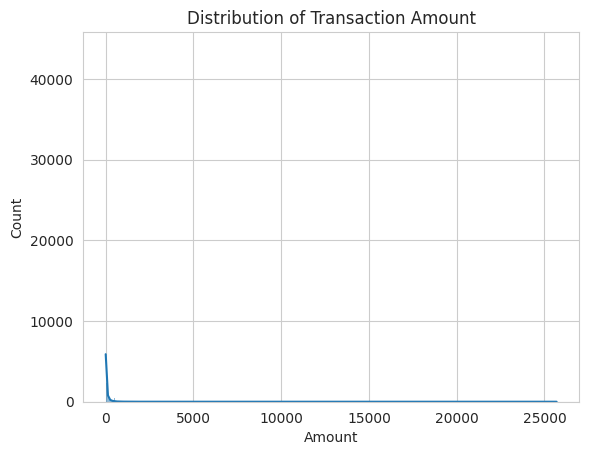

In [12]:
# Amount distribution
sns.histplot(data=df, x='Amount', kde=True)
plt.title("Distribution of Transaction Amount");

The distribution is highly skewed to the right, with the majority of transactions involving small amounts. Apply log transformation to handle the skewness and drop the skewed `Amount` column

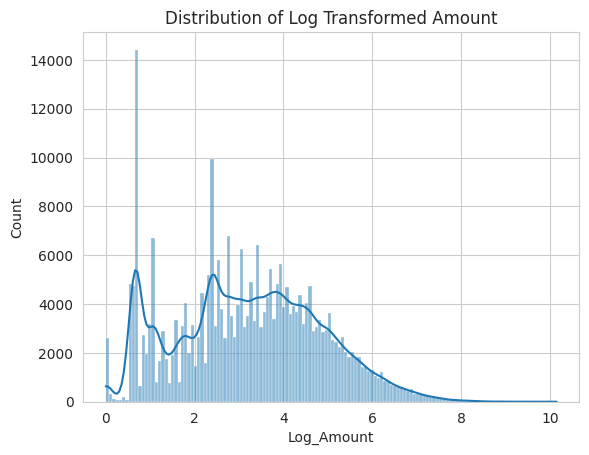

In [13]:
# Log-transformation for skew data
df["Log_Amount"] = np.log1p(df['Amount'])
df.drop("Amount", axis=1, inplace=True)

# Plot the log amount
sns.histplot(data=df, x="Log_Amount", kde=True)
plt.title("Distribution of Log Transformed Amount");

#### 2.2    Bivariate Analysis

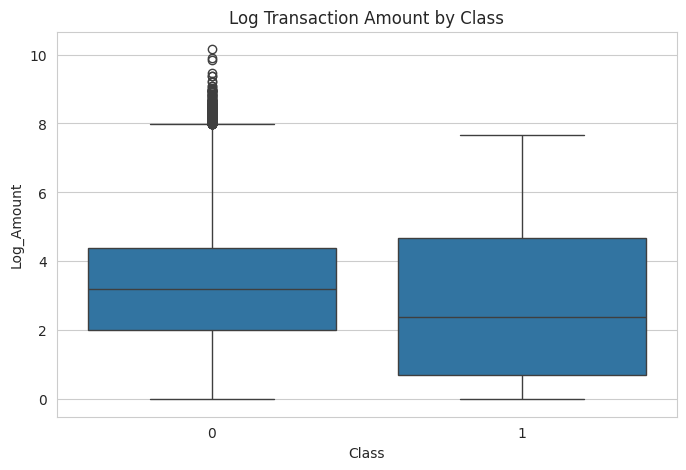

In [14]:
# Check outliers using Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Log_Amount', data=df)
plt.title('Log Transaction Amount by Class')
plt.show()

The outliers present in the legit transaction class can be rare case and is fine to keep for now

### 2.3 Multivariate Analysis

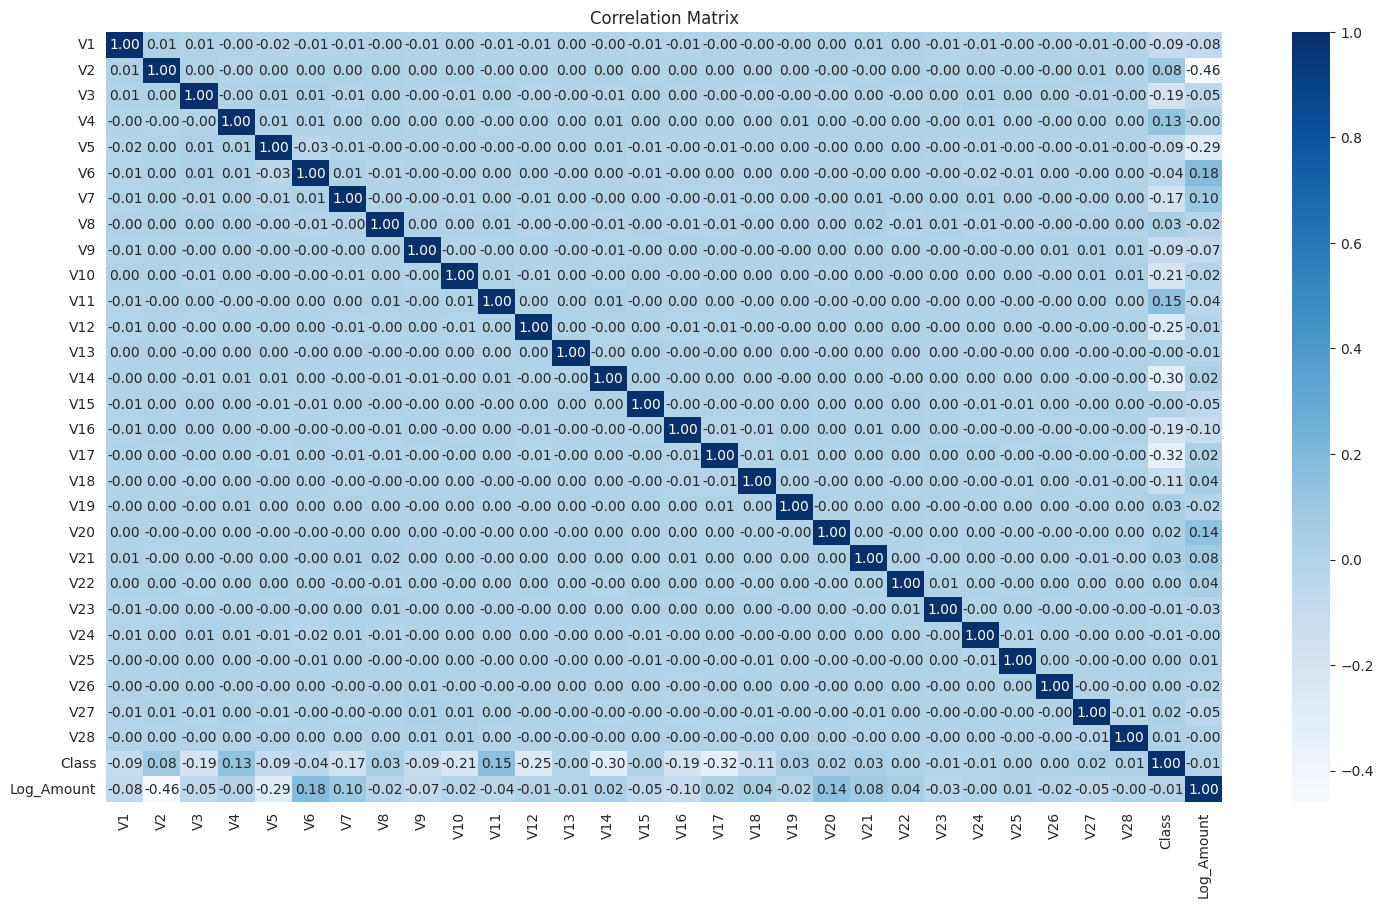

In [15]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The features are mostly uncorrelated with each other means no linear relationship.

In [16]:
# Top 5 correlated features with target
corr_with_target = df.corrwith(df["Class"], method="pearson").abs().drop(labels=["Class"], errors="ignore")
corr_with_target.sort_values(ascending=False).head(5)

V17    0.317202
V14    0.297550
V12    0.253150
V10    0.208104
V16    0.188222
dtype: float64

## Data Preprocessing

### 1. Train Test Split

In [17]:
# Seprate the features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Initial Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Shape after the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((220530, 29), (55133, 29), (220530,), (55133,))

### 2. Feature Scaling

In [18]:
# Instantiate the scaler
scaler = RobustScaler()

# Scale all features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

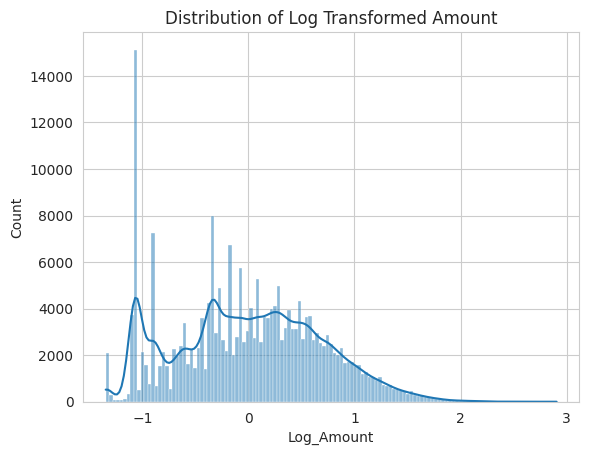

In [19]:
# Plot the log amount
sns.histplot(data=pd.DataFrame(X_train_scaled, columns=X_train.columns), x="Log_Amount", kde=True)
plt.title("Distribution of Log Transformed Amount");

### 3. Class Imbalance Handling

#### 3.1 Resampling using Tomek (Under-Sampling Technique) 

In [20]:
tomek = TomekLinks(n_jobs=-1)
X_train_res1, y_train_res1 = tomek.fit_resample(X_train_scaled, y_train)
X_train_res1.shape, y_train_res1.shape

((220510, 29), (220510,))

#### 3.2 Resampling using SMOTE (Over-Sampling Technique)

In [21]:
smote = SMOTE(random_state=42)
X_train_res2, y_train_res2 = smote.fit_resample(X_train_scaled, y_train)
X_train_res2.shape, y_train_res2.shape

((440304, 29), (440304,))

#### 3.3 Resampling using SMOTE + Tomek (Hybrid-Sampling Technique)

In [22]:
smote_tomek = SMOTETomek(random_state=42, n_jobs=-1)
X_train_res3, y_train_res3 = smote_tomek.fit_resample(X_train_scaled, y_train)
X_train_res3.shape, y_train_res3.shape

((440304, 29), (440304,))

## Model Development

### Baseline Model

In [23]:
# MLflow experiment setup
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment(experiment_name="fraud_detection_baseline")

# Map pre-resampled datasets to names
resampled_datasets = {
    "TomekLinks": (X_train_res1, y_train_res1),
    "SMOTE": (X_train_res2, y_train_res2),
    "SMOTE_Tomek": (X_train_res3, y_train_res3),
}

# Outer training loop
for resample_name, (X_train_res, y_train_res) in resampled_datasets.items():
    print("---"*10 + f" Training on {resample_name} resampled data " + "---"*10)

    # Per-resample imbalance for XGBoost
    neg_count = int(np.sum(y_train_res == 0))
    pos_count = int(np.sum(y_train_res == 1))
    scale_pos_weight_val = neg_count / pos_count if pos_count > 0 else 1.0

    # Models (CPU-friendly hyperparams)
    models = {
        "MLPClassifier": MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation='relu',
            solver='adam',
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=200,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42,
            verbose=False
        ),
        "LogisticRegression": LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='lbfgs',
            max_iter=500,
            n_jobs=-1,
            random_state=42
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ),
        "XGBoost": XGBClassifier(
            booster='gbtree',
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=5,
            gamma=0,
            reg_lambda=1,
            reg_alpha=0,
            scale_pos_weight=scale_pos_weight_val,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1,
            tree_method='hist'
        )
    }

    for model_name, model in models.items():
        print(f"- Training {model_name} model")
        with mlflow.start_run(run_name=f"{resample_name}_{model_name}"):

            # Train
            if model_name == "XGBoost":
                model.set_params(early_stopping_rounds=50)
                model.fit(X_train_res, y_train_res, eval_set=[(X_test_scaled, y_test)], verbose=False)
            else:
                model.fit(X_train_res, y_train_res)

            # Predictions & probabilities
            y_pred = model.predict(X_test_scaled)

            # safe get probabilities (fallback to decision function is not needed here; all models used have predict_proba)
            try:
                y_prob = model.predict_proba(X_test_scaled)[:, 1]
            except Exception:
                # fallback: use decision_function and scale to 0-1 via sigmoid (rare for these models)
                from scipy.special import expit
                y_prob = expit(model.decision_function(X_test_scaled))

            # Core metrics
            ap_score = average_precision_score(y_test, y_prob)
            metrics = {
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_prob),
                "avg_precision": float(ap_score)
            }
            # log metrics
            mlflow.log_metrics(metrics)
            mlflow.log_params({"resampling": resample_name, "model": model_name})

            # --- Confusion Matrix artifact ---
            cm = confusion_matrix(y_test, y_pred)
            fig_cm, ax_cm = plt.subplots()
            ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax_cm, cmap='Blues', colorbar=True)
            fig_cm.tight_layout()
            mlflow.log_figure(fig_cm, f"confusion_matrix_{resample_name}_{model_name}.png")
            plt.close(fig_cm)

            # --- ROC Curve artifact ---
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            fig_roc, ax_roc = plt.subplots()
            ax_roc.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
            ax_roc.plot([0, 1], [0, 1], 'k--')
            ax_roc.set_xlabel("False Positive Rate")
            ax_roc.set_ylabel("True Positive Rate")
            ax_roc.set_title("ROC Curve")
            ax_roc.legend(loc="lower right")
            fig_roc.tight_layout()
            mlflow.log_figure(fig_roc, f"roc_curve_{resample_name}_{model_name}.png")
            plt.close(fig_roc)

            # --- Precision-Recall Curve artifact ---
            prec, rec, _ = precision_recall_curve(y_test, y_prob)
            fig_pr, ax_pr = plt.subplots()
            ax_pr.plot(rec, prec, label=f"AP = {ap_score:.3f}")
            ax_pr.set_xlabel("Recall")
            ax_pr.set_ylabel("Precision")
            ax_pr.set_title("Precision–Recall Curve")
            ax_pr.legend(loc="lower left")
            fig_pr.tight_layout()
            mlflow.log_figure(fig_pr, f"pr_curve_{resample_name}_{model_name}.png")
            plt.close(fig_pr)

            # --- Minimal metadata ---
            try:
                mlflow.set_tags({
                    "project": "fraud_detection",
                    "owner": "Vipin Kumar",
                    "model": model_name,
                    "resampling": resample_name,
                    "hardware": "CPU"
                })
                # log hyperparameters
                for k, v in model.get_params().items():
                    try:
                        mlflow.log_param(f"hyperparameter_{k}", v)
                    except Exception:
                        mlflow.log_param(f"hyperparameter_{k}", str(v))
                # dataset summary as small json artifact & params
                dataset_stats = {
                    "X_train_shape": X_train_res.shape,
                    "y_train_shape": y_train_res.shape,
                    "X_test_shape": getattr(X_test_scaled, "shape", None),
                    "y_test_shape": getattr(y_test, "shape", None),
                    "train_neg": int((y_train_res == 0).sum()),
                    "train_pos": int((y_train_res == 1).sum()),
                    "scale_pos_weight": float(scale_pos_weight_val),
                }
                mlflow.log_dict(dataset_stats, f"dataset_stats_{resample_name}_{model_name}.json")
                mlflow.log_params({
                    "train_pos": dataset_stats["train_pos"],
                    "train_neg": dataset_stats["train_neg"],
                    "scale_pos_weight": dataset_stats["scale_pos_weight"]
                })
            except Exception:
                pass

            # --- Log model with signature & input_example (preferred) ---
            try:
                # Build a small input example from test set
                if isinstance(X_test_scaled, pd.DataFrame):
                    input_example = X_test_scaled.head(5)
                else:
                    input_example = pd.DataFrame(X_test_scaled[:5])
                # try infer signature using predict_proba
                try:
                    preds_example = model.predict_proba(input_example)
                    signature = infer_signature(input_example, preds_example)
                except Exception:
                    signature = None
                # log model with name="model"
                log_kwargs = {"input_example": input_example}
                if signature is not None:
                    log_kwargs["signature"] = signature
                mlflow.sklearn.log_model(model, name="model", **log_kwargs)
            except Exception as e:
                # fallback to older param name if needed
                try:
                    mlflow.sklearn.log_model(model, name="model")
                except Exception:
                    print("Model logging failed:", e)

2025/08/13 14:57:44 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_baseline' does not exist. Creating a new experiment.


------------------------------ Training on TomekLinks resampled data ------------------------------
- Training MLPClassifier model
🏃 View run TomekLinks_MLPClassifier at: http://127.0.0.1:5000/#/experiments/1/runs/a519f4930c2f4f6588679a4063fb454b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
- Training LogisticRegression model
🏃 View run TomekLinks_LogisticRegression at: http://127.0.0.1:5000/#/experiments/1/runs/c147eb988d5145f7a9b81a3674ffef5b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
- Training RandomForest model
🏃 View run TomekLinks_RandomForest at: http://127.0.0.1:5000/#/experiments/1/runs/d06c72ec8c784cca82e6cf83d5fb8eb9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
- Training XGBoost model
🏃 View run TomekLinks_XGBoost at: http://127.0.0.1:5000/#/experiments/1/runs/c704c19dc67340f5a246eb390b09be91
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
------------------------------ Training on SMOTE resampled data ------------

In [24]:
# Get experiment ID by name
experiment_name = "fraud_detection_baseline"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Experiment '{experiment_name}' not found.")

# Fetch all runs for this experiment
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=["metrics.avg_precision DESC"])

# Keep only relevant columns
results_df = runs[["params.resampling", "params.model", "metrics.precision", "metrics.avg_precision", "metrics.recall", "metrics.f1", "metrics.roc_auc",]]
results_df

,params.resampling,params.model,metrics.precision,metrics.avg_precision,metrics.recall,metrics.f1,metrics.roc_auc
0,TomekLinks,XGBoost,0.844444,0.827083,0.800000,0.821622,0.978663
1,TomekLinks,MLPClassifier,0.880952,0.822506,0.778947,0.826816,0.975262
2,TomekLinks,RandomForest,0.862069,0.808084,0.789474,0.824176,0.969666
3,SMOTE_Tomek,XGBoost,0.700935,0.807065,0.789474,0.742574,0.969718
4,SMOTE,XGBoost,0.700935,0.807065,0.789474,0.742574,0.969718
5,SMOTE_Tomek,RandomForest,0.710280,0.800515,0.800000,0.752475,0.979383
6,SMOTE,RandomForest,0.710280,0.800515,0.800000,0.752475,0.979383
7,SMOTE_Tomek,MLPClassifier,0.718447,0.775680,0.778947,0.747475,0.945597
8,SMOTE,MLPClassifier,0.718447,0.775680,0.778947,0.747475,0.945597
9,TomekLinks,LogisticRegression,0.848485,0.732980,0.589474,0.695652,0.971214


#### Observations

1. Impact of Resampling:
    * Models trained on data resampled with **TomekLinks** demonstrated the best overall performance, achieving a strong balance between precision and recall. These models were effective at identifying fraud without flagging an excessive number of legitimate transactions.
    * Models trained with **SMOTE** and **SMOTE+Tomek** achieved very high recall (catching most of the fraud cases) but at the cost of extremely low precision. This would lead to a high number of false positives, which is undesirable in a real-world scenario.

2. Best Model Performance:
    * The **XGBoost** classifier trained on the **TomekLinks** resampled data emerged as the top-performing model.
    * This combination achieved the highest Average Precision score of 0.827 and a high F1-score of 0.822. It also had a strong recall of 0.80 and a precision of 0.844.

### Hyperparameter Tuning

In [25]:
# Set up MLflow tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("fraud_detection_tuning")

# Initialize MLflow client for model registry operations
client = MlflowClient()

# Global variables to track best model
best_avg_precision = 0
best_run_id = None
best_model = None
best_params = None

2025/08/13 15:08:29 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_tuning' does not exist. Creating a new experiment.


In [26]:
def objective(trial):
    global best_avg_precision, best_run_id, best_model, best_params

    # Suggest hyperparameters optimized for CPU (i5 10th gen, 12GB RAM)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'booster': 'gbtree',
        'eval_metric': 'logloss'
    }

    # Start MLflow run for this trial
    with mlflow.start_run(run_name=f"trial_{trial.number}"):
        # Calculate scale_pos_weight for resampled data
        neg_count = int(np.sum(y_train_res1 == 0))
        pos_count = int(np.sum(y_train_res1 == 1))
        scale_pos_weight_val = neg_count / pos_count if pos_count > 0 else 1.0

        # Update params with scale_pos_weight
        params['scale_pos_weight'] = scale_pos_weight_val

        # Train model on resampled training data
        model = XGBClassifier(**params)
        model.fit(X_train_res1, y_train_res1, verbose=False)

        # Predict on test set
        y_test_pred = model.predict(X_test_scaled)
        y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate test metrics
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_prob)
        test_avg_precision = average_precision_score(y_test, y_test_prob)

        # Log all hyperparameters
        mlflow.log_params(params)

        # Log test metrics
        test_metrics = {
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1,
            "test_roc_auc": test_roc_auc,
            "test_avg_precision": test_avg_precision,
        }
        mlflow.log_metrics(test_metrics)

        # Check if this is the best model so far
        if test_avg_precision > best_avg_precision:

            # Create and log visualizations
            # Confusion Matrix
            cm = confusion_matrix(y_test, y_test_pred)
            fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
            ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax_cm, cmap='Blues', colorbar=True)
            ax_cm.set_title(f'Confusion Matrix - Trial {trial.number}')
            fig_cm.tight_layout()
            mlflow.log_figure(fig_cm, f"confusion_matrix_trial_{trial.number}.png")
            plt.close(fig_cm)

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
            ax_roc.plot(fpr, tpr, label=f"AUC = {test_roc_auc:.3f}")
            ax_roc.plot([0, 1], [0, 1], 'k--')
            ax_roc.set_xlabel("False Positive Rate")
            ax_roc.set_ylabel("True Positive Rate")
            ax_roc.set_title(f"ROC Curve - Trial {trial.number}")
            ax_roc.legend(loc="lower right")
            fig_roc.tight_layout()
            mlflow.log_figure(fig_roc, f"roc_curve_trial_{trial.number}.png")
            plt.close(fig_roc)

            # Precision-Recall Curve
            prec, rec, _ = precision_recall_curve(y_test, y_test_prob)
            fig_pr, ax_pr = plt.subplots(figsize=(8, 6))
            ax_pr.plot(rec, prec, label=f"AP = {test_avg_precision:.3f}")
            ax_pr.set_xlabel("Recall")
            ax_pr.set_ylabel("Precision")
            ax_pr.set_title(f"Precision-Recall Curve - Trial {trial.number}")
            ax_pr.legend(loc="lower left")
            fig_pr.tight_layout()
            mlflow.log_figure(fig_pr, f"pr_curve_trial_{trial.number}.png")
            plt.close(fig_pr)

            # Log model with signature and input example
            try:
                if hasattr(X_test_scaled, 'head'):
                    input_example = X_test_scaled.head(5)
                else:
                    input_example = pd.DataFrame(X_test_scaled[:5])

                signature = infer_signature(input_example, model.predict_proba(input_example))
                mlflow.xgboost.log_model(
                    model,
                    name="model",
                    signature=signature,
                    input_example=input_example
                )
            except Exception as e:
                print(f"Model logging failed for trial {trial.number}: {e}")
                mlflow.xgboost.log_model(model, name="model")

            # Update best model tracking
            best_avg_precision = test_avg_precision
            best_run_id = mlflow.active_run().info.run_id
            best_model = model
            best_params = params.copy()

            print(f"New best model found in trial {trial.number}! Test Avg Precision: {test_avg_precision:.4f}")

        # Log tags
        mlflow.set_tags({
            "project": "fraud_detection_tuning",
            "model": "XGBoost",
            "resampling": "TomekLinks",
            "optimization_metric": "avg_precision",
            "trial_number": trial.number
        })

        # Log dataset info
        dataset_info = {
            "train_resampled_shape": X_train_res1.shape,
            "test_shape": X_test_scaled.shape,
            "resampling_method": "TomekLinks",
            "scale_pos_weight": scale_pos_weight_val
        }
        mlflow.log_dict(dataset_info, "dataset_info.json")

    return test_avg_precision

In [27]:
print("\n" + "="*50)
print("STARTING MODEL OPTIMIZATION")
print("="*50)

# Run Optuna optimization
study = optuna.create_study(direction='maximize', study_name='xgboost_tomeklinks_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Print optimization results
print("\n" + "="*50)
print("OPTIMIZATION COMPLETE!")
print("="*50)
print(f"Best Test Average Precision: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")
print(f"Best run ID: {best_run_id}")

# Register the best model
print("\n" + "="*50)
print("REGISTERING BEST MODEL")
print("="*50)

model_name = "fraud_detection_xgboost_tomeklinks"

try:
    # Register the model
    model_version = mlflow.register_model(
        model_uri=f"runs:/{best_run_id}/model",
        name=model_name,
        tags={
            "model_type": "XGBoost",
            "resampling": "TomekLinks",
            "optimization_trials": 50,
            "best_cv_avg_precision": best_avg_precision,
            "hardware": "CPU_i5_10th_gen_12GB"
        }
    )

    print(f"Model registered successfully!")
    print(f"Model name: {model_name}")
    print(f"Model version: {model_version.version}")

    # Transition model to Staging
    client.transition_model_version_stage(
        name=model_name,
        version=model_version.version,
        stage="Staging",
        archive_existing_versions=False
    )

    print(f"Model version {model_version.version} promoted to Staging!")

    # Add model version description
    client.update_model_version(
        name=model_name,
        version=model_version.version,
        description=f"Best XGBoost model with TomekLinks resampling. "
                   f"Optimized using 50 Optuna trials on test set. "
                   f"Best Test Average Precision: {best_avg_precision:.4f}. "
                   f"Trained on CPU (i5 10th gen, 12GB RAM)."
    )

except Exception as e:
    print(f"Error during model registration: {e}")

[I 2025-08-13 15:08:29,772] A new study created in memory with name: xgboost_tomeklinks_optimization



STARTING MODEL OPTIMIZATION


  0%|          | 0/50 [00:00<?, ?it/s]

New best model found in trial 0! Test Avg Precision: 0.8301
🏃 View run trial_0 at: http://127.0.0.1:5000/#/experiments/2/runs/14249e08479a49c48ef96e17d6d01c7d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
[I 2025-08-13 15:08:38,365] Trial 0 finished with value: 0.8301472057912268 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.14440045043399335, 'subsample': 0.7724567754950392, 'colsample_bytree': 0.7109747754116086, 'min_child_weight': 7, 'gamma': 0.4503079161596, 'reg_alpha': 0.32878146155949073, 'reg_lambda': 0.10083536021857487}. Best is trial 0 with value: 0.8301472057912268.
🏃 View run trial_1 at: http://127.0.0.1:5000/#/experiments/2/runs/b507359638464d22b580dbadbdfeab59
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
[I 2025-08-13 15:08:43,684] Trial 1 finished with value: 0.8293715288767504 and parameters: {'n_estimators': 215, 'max_depth': 8, 'learning_rate': 0.07449533346257048, 'subsample': 0.8404672965742126, 'colsample_by

Successfully registered model 'fraud_detection_xgboost_tomeklinks'.
2025/08/13 15:13:24 WARNING mlflow.tracking._model_registry.fluent: Run with id 4369a8484bb04540bf968e7a310f3023 has no artifacts at artifact path 'model', registering model based on models:/m-73ace9622f6a49329c5e00fc9e280ea3 instead


🏃 View run trial_49 at: http://127.0.0.1:5000/#/experiments/2/runs/86249f8688414149a34d3805fd4ad60c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
[I 2025-08-13 15:13:23,939] Trial 49 finished with value: 0.8391639854122739 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.06222336645275074, 'subsample': 0.8395785311321925, 'colsample_bytree': 0.7460323850593231, 'min_child_weight': 5, 'gamma': 0.0008013099674381574, 'reg_alpha': 0.7888494233989192, 'reg_lambda': 0.36480706732676615}. Best is trial 30 with value: 0.8469767303646946.

OPTIMIZATION COMPLETE!
Best Test Average Precision: 0.8470
Best parameters: {'n_estimators': 461, 'max_depth': 5, 'learning_rate': 0.17152393209792188, 'subsample': 0.8598026756023806, 'colsample_bytree': 0.7875283309591229, 'min_child_weight': 9, 'gamma': 0.44664097438496964, 'reg_alpha': 0.6986841003997439, 'reg_lambda': 0.2555338089467246}
Best run ID: 4369a8484bb04540bf968e7a310f3023

REGISTERING BEST MODEL


2025/08/13 15:13:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: fraud_detection_xgboost_tomeklinks, version 1
Created version '1' of model 'fraud_detection_xgboost_tomeklinks'.


Model registered successfully!
Model name: fraud_detection_xgboost_tomeklinks
Model version: 1
Model version 1 promoted to Staging!
